# SF Salt Ponds preliminary biogeochemical analysis
### modified from Salinity Gradient script, many deletions

Data pre-processing for comparison to genomic data, 
with correlation heatmaps and scatterplots

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Import metadata, requires cleanup

In [10]:
Sal_metaM = pd.read_csv('Salt_pond_ALL_Meta_whh.txt', sep='\t')

# Sal_metaM = pd.read_csv('SAL_Metadata_MSTRv0.txt', sep='\t')
# Sal_metaM.iloc[1:10,1:35]
# Sal_metaM
Sal_metaM.columns
# Sal_metaM.dtypes
# Sal_metaM.iloc[1:10,1:25]

Index(['New_index', 'Sample_name', 'Sample', 'Site', 'Core', 'Depth',
       'Restoration', 'Hydrol', 'Date', 'Lat', 'Long', 'Salinity',
       'Cond_uS_cm', 'Temp', 'DO_perc', 'DO_mg_L', 'Redox', 'pH_YSI',
       'CH4_umol_m2_d', 'CO2_umol_m2_d', 'pH', 'Cl', 'SO4_S', 'TOC', 'OM_LOI',
       'C_Org_LOI', 'C', 'N', 'P', 'NO3', 'NH4', 'Olsen_P', 'K_ppm', 'K_meq',
       'Na_ppm', 'Na_meq', 'Ca', 'Mg', 'Zn', 'Mn', 'Cu', 'Fe'],
      dtype='object')

## Metadata massage: 
Makes sense to first add desired features to big dataset, then include in desired order in subsets

### Calculate new features:

In [11]:
### Carbonates ###
Sal_metaM['CaCO3'] = (Sal_metaM['C_Org_LOI']) - (Sal_metaM['TOC'])

### GHG cycling ###
# Note Bulk Density data not present
Sal_metaM['CH4_CO2'] = Sal_metaM['CH4_umol_m2_d']/Sal_metaM['CO2_umol_m2_d']
Sal_metaM['CH4_pos'] = Sal_metaM['CH4_umol_m2_d'] + 25
Sal_metaM['CH4_CO2_pos'] =  Sal_metaM['CH4_CO2'] - Sal_metaM['CH4_CO2'].min()

### Stoichiometry ###
Sal_metaM['CN'] = (Sal_metaM['TOC']/12.011) / (Sal_metaM['N']/14.007)  #  ratios accounting for mol. masses
Sal_metaM['CP'] = (Sal_metaM['TOC']/12.011) / (Sal_metaM['P']/30.974) 
Sal_metaM['NP'] = (Sal_metaM['N']/14.007) / (Sal_metaM['P']/30.974) 

#Sal_metaM['NP_ext'] = (Sal_metaM['NO3']/14.007) / (Sal_metaM['P']/31.007) 
Sal_metaM['NP_ext'] = ((Sal_metaM['NO3'] + Sal_metaM['NH4'])/14.007) / (Sal_metaM['P']/31.007) 
Sal_metaM['NO3_NH4'] = (Sal_metaM['NO3']) / (Sal_metaM['NH4'])    


In [12]:
Sal_metaM

,New_index,Sample_name,Sample,Site,Core,Depth,Restoration,Hydrol,Date,Lat,...,Fe,CaCO3,CH4_CO2,CH4_pos,CH4_CO2_pos,CN,CP,NP,NP_ext,NO3_NH4
0,1,Historic_R2A_A_D1,R2A_A_D1,R2A,A,D1,Historic,Tidal marsh,7/11/14,37.496219,...,296.4,0.42,-0.000081,0.70,0.000000,13.956953,118.414413,8.484259,322.112865,0.108865
1,2,Historic_R2A_A_D2,R2A_A_D2,R2A,A,D2,Historic,Tidal marsh,7/11/14,37.496219,...,367.6,0.52,-0.000081,0.70,0.000000,13.874564,127.294094,9.174638,127.168786,0.102041
2,3,Historic_R2A_B_D1,R2A_B_D1,R2A,B,D1,Historic,Tidal marsh,7/11/14,37.496044,...,269.5,0.61,-0.000009,23.24,0.000072,15.130620,159.606982,10.548608,227.949095,0.006605
3,4,Historic_R2A_B_D2,R2A_B_D2,R2A,B,D2,Historic,Tidal marsh,7/11/14,37.496044,...,402.0,0.75,-0.000009,23.24,0.000072,13.782139,221.777038,16.091627,309.915042,0.172680
4,5,Historic_R2A_C_D1,R2A_C_D1,R2A,C,D1,Historic,Tidal marsh,7/11/14,37.496546,...,99.4,1.29,-0.000027,17.90,0.000054,16.433834,185.291754,11.275017,332.871712,0.076923
5,6,Historic_R2A_C_D2,R2A_C_D2,R2A,C,D2,Historic,Tidal marsh,7/11/14,37.496546,...,443.1,0.25,-0.000027,17.90,0.000054,16.266288,171.015341,10.513483,124.276709,0.015873
6,7,restored_SF2_A_D1,SF2_A_D1,SF2,A,D1,Restored,Managed pond,7/17/14,37.497143,...,318.8,0.47,0.000053,29.43,0.000134,10.352195,72.556146,7.008769,875.341155,0.002148
7,8,restored_SF2_A_D2,SF2_A_D2,SF2,A,D2,Restored,Managed pond,7/17/14,37.497143,...,395.1,0.29,0.000053,29.43,0.000134,12.198867,69.496549,5.696967,947.754718,0.001983
8,9,restored_SF2_B_D1,SF2_B_D1,SF2,B,D1,Restored,Managed pond,7/17/14,37.497202,...,301.7,0.32,0.000285,66.45,0.000366,10.789899,118.744871,11.005188,1606.204207,0.001605
9,10,restored_SF2_B_D2,SF2_B_D2,SF2,B,D2,Restored,Managed pond,7/17/14,37.497202,...,188.5,2.66,0.000285,66.45,0.000366,12.936325,116.332658,8.992713,2394.216685,0.001028


### Subset data by type

In [6]:
# Define metadata SUBSETS for manipulation

### Samp_info
samp_dat = ['New_index', 'Sample_name', 'Sample', 'Site', 'Core', 'Depth',
       'Restoration', 'Hydrol', 'Date', 'Lat', 'Long']
Samp_info = Sal_metaM[samp_dat]
Samp_info.head(10)

### Soil_Chem 
soils_dat = ['Salinity',
       'Cond_uS_cm', 'Temp', 'DO_perc', 'DO_mg_L', 'Redox', 'pH_YSI',
       'CH4_umol_m2_d', 'CO2_umol_m2_d', 'CH4_CO2', 'CH4_pos', 'CH4_CO2_pos','pH', 'Cl', 'SO4_S', 'TOC', 'OM_LOI',
       'C_Org_LOI', 'CaCO3', 'C', 'N', 'P', 'CN','CP', 'NP','NO3', 'NH4', 'Olsen_P', 'NP_ext','NO3_NH4','K_ppm', 'K_meq',
       'Na_ppm', 'Na_meq', 'Ca', 'Mg', 'Zn', 'Mn', 'Cu', 'Fe']
Soil_chem = Sal_metaM[soils_dat]

# Soil_chem.head(10)
# Samp_info.head(10)
# Soil_chem
Soil_chem["CN"]

0     13.956953
1     13.874564
2     15.130620
3     13.782139
4     16.433834
5     16.266288
6     10.352195
7     12.198867
8     10.789899
9     12.936325
10    11.595550
11    11.975300
12     8.700080
13     9.923873
14     8.560009
15     8.460529
16     8.268826
17     8.604831
18     9.206692
19     8.542396
20     8.346778
21     8.842089
22     9.971693
23     8.955965
Name: CN, dtype: float64

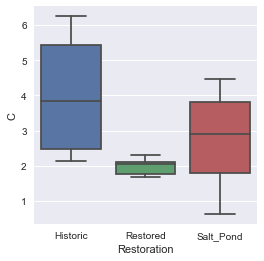

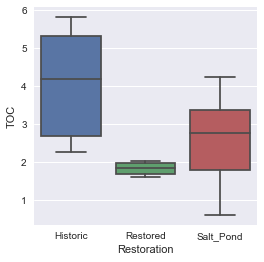

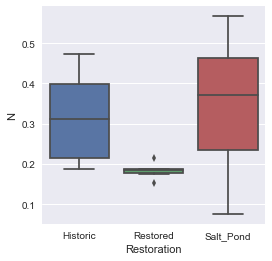

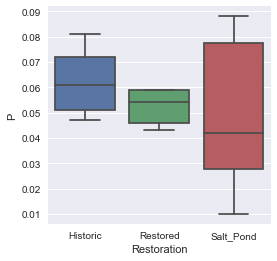

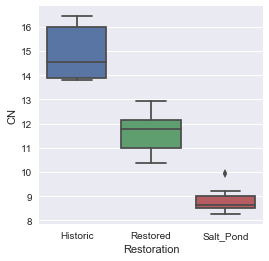

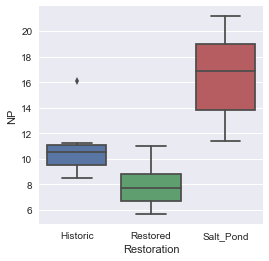

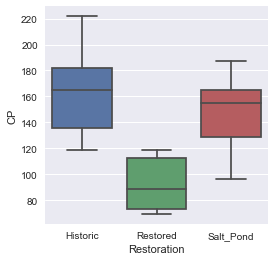

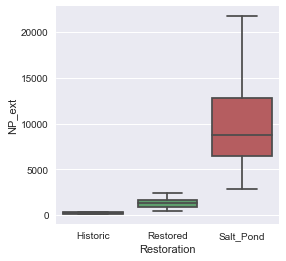

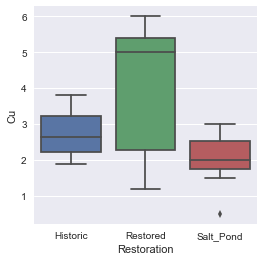

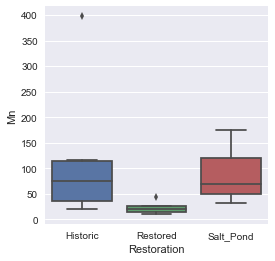

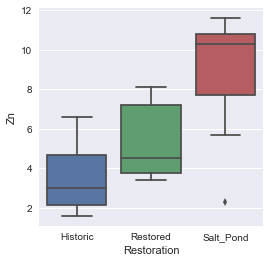

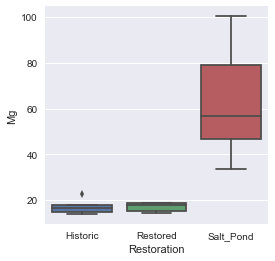

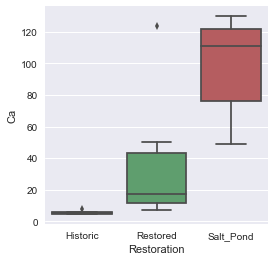

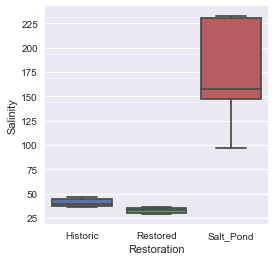

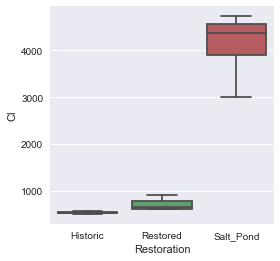

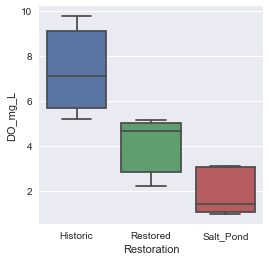

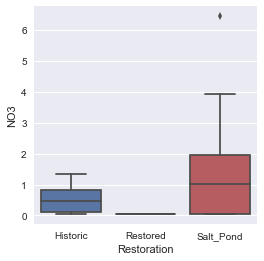

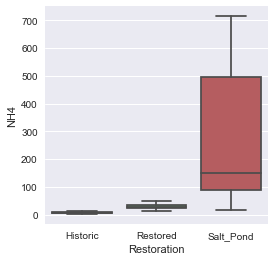

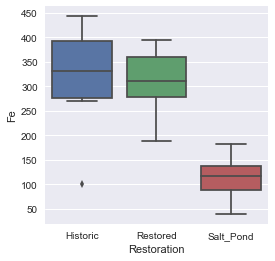

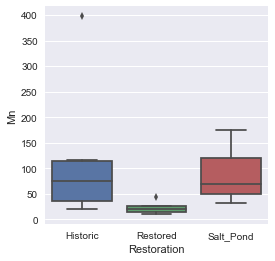

In [7]:
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="C", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="TOC", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="N", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="P", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="CN", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="NP", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="CP", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="NP_ext", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Cu", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Mn", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Zn", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Mg", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Ca", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Salinity", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Cl", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="DO_mg_L", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="NO3", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="NH4", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Fe", data=Sal_metaM)
plt.figure(figsize=(4,4))
sns.boxplot(x="Restoration", y="Mn", data=Sal_metaM)

## spearman correlation

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
         36.5,  37.5,  38.5,  39.5]), <a list of 40 Text yticklabel objects>)

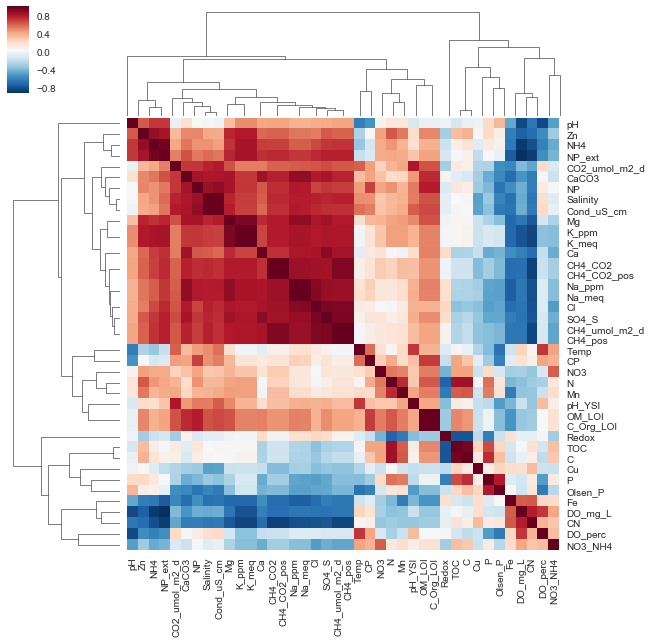

In [27]:
corr_spearman = Soil_chem.corr(method="spearman")
# Emphasize CH4 related subset
cm=sns.clustermap(corr_spearman, vmax=1, row_cluster=True, col_cluster=True, square=True,cmap="RdBu_r");
# cm.cax.set_visible(False) - turns legend off, but doesn't fix whitespace
plt.sca(cm.ax_heatmap) # for tick rotation
plt.yticks(rotation=0)


In [102]:
corr_spearman["Salinity"].sort_values()

Fe              -0.659113
CN              -0.641676
Olsen_P         -0.579029
Cu              -0.470537
DO_mg_L         -0.433566
P               -0.306483
NO3_NH4         -0.069747
Redox           -0.041958
pH               0.034881
TOC              0.043592
C                0.059311
DO_perc          0.209790
NO3              0.304088
N                0.355712
Mn               0.381867
Zn               0.417794
NH4              0.477770
CP               0.481257
Temp             0.489510
pH_YSI           0.538462
NP_ext           0.584135
Ca               0.622631
OM_LOI           0.657369
C_Org_LOI        0.657369
K_meq            0.706346
K_ppm            0.706346
CH4_CO2_pos      0.769231
CH4_CO2          0.769231
Mg               0.773493
SO4_S            0.774533
CO2_umol_m2_d    0.783217
Cl               0.790061
CH4_umol_m2_d    0.790210
CH4_pos          0.790210
Na_meq           0.796165
Na_ppm           0.798608
CaCO3            0.814301
NP               0.859637
Cond_uS_cm  

In [111]:
corr_spearman["Cl"].sort_values()

CN              -0.779300
Fe              -0.678843
DO_mg_L         -0.648792
NO3_NH4         -0.479670
P               -0.479094
Olsen_P         -0.450196
Cu              -0.348792
TOC             -0.343118
C               -0.308897
DO_perc         -0.078483
N                0.026093
NO3              0.054036
CP               0.110024
Temp             0.130805
Mn               0.135682
Redox            0.256377
C_Org_LOI        0.376604
OM_LOI           0.376604
pH_YSI           0.381950
pH               0.392344
Zn               0.534261
CO2_umol_m2_d    0.647048
NH4              0.679713
NP               0.691455
NP_ext           0.767558
Cond_uS_cm       0.769132
Salinity         0.790061
CaCO3            0.805827
K_ppm            0.813832
K_meq            0.813832
Mg               0.827099
Ca               0.833841
CH4_CO2_pos      0.852847
CH4_CO2          0.852847
Na_ppm           0.917591
Na_meq           0.918225
CH4_umol_m2_d    0.934818
CH4_pos          0.934818
SO4_S       

In [28]:
corr_spearman["CH4_umol_m2_d"].sort_values()

CN              -0.828250
Fe              -0.638189
DO_mg_L         -0.636364
NO3_NH4         -0.453358
Olsen_P         -0.384566
P               -0.353635
Cu              -0.336098
TOC             -0.238885
C               -0.185783
DO_perc         -0.111888
Temp             0.027972
Redox            0.083916
CP               0.109852
NO3              0.148243
N                0.172625
Mn               0.195293
pH_YSI           0.342657
C_Org_LOI        0.420228
OM_LOI           0.420228
pH               0.422936
Zn               0.607939
CO2_umol_m2_d    0.636364
NP               0.707936
NH4              0.739322
Cond_uS_cm       0.741259
CaCO3            0.781171
NP_ext           0.788146
Salinity         0.790210
Mg               0.809246
K_ppm            0.817094
K_meq            0.817094
Ca               0.839767
Na_meq           0.866800
Na_ppm           0.868355
CH4_CO2_pos      0.930070
CH4_CO2          0.930070
Cl               0.934818
SO4_S            0.942872
CH4_pos     

## plot chemicals with > 0.6 correlation(spearman) with CH4

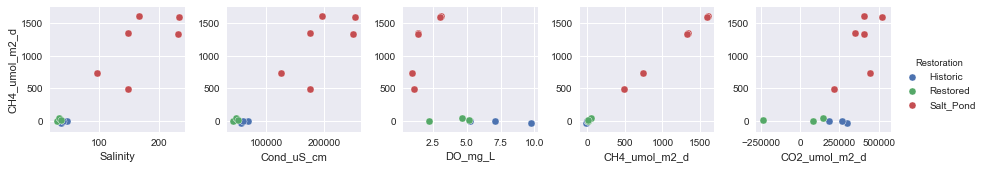

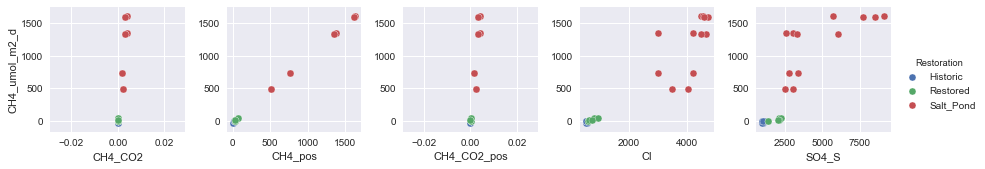

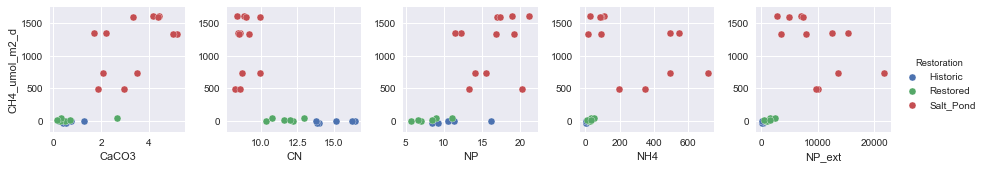

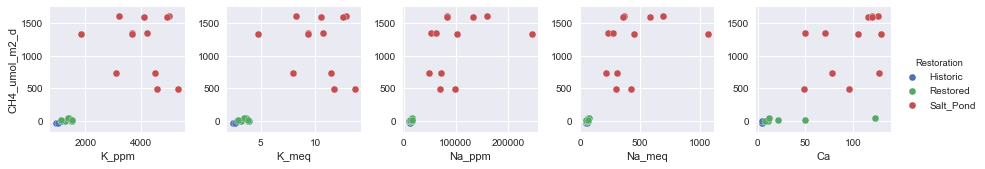

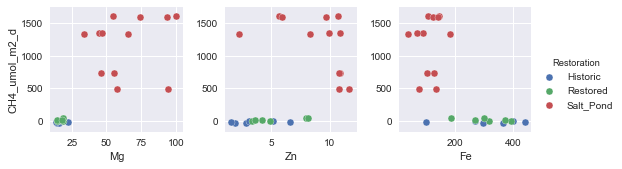

In [29]:
## linear plot
Hcor_CH4 = Soil_chem.loc[:,abs(corr_spearman["CH4_umol_m2_d"].sort_values()) > 0.6]
Hcor_CH4_metaM = pd.concat([Sal_metaM.iloc[:,:11],Hcor_CH4],1)
#Hcor_CH4_metaM.columns[11:]
g1= sns.pairplot(y_vars=['CH4_umol_m2_d'], x_vars = Hcor_CH4_metaM.columns[11:16], hue='Restoration', data=Hcor_CH4_metaM)
g2= sns.pairplot(y_vars=['CH4_umol_m2_d'], x_vars = Hcor_CH4_metaM.columns[16:21], hue='Restoration', data=Hcor_CH4_metaM)
g3= sns.pairplot(y_vars=['CH4_umol_m2_d'], x_vars = Hcor_CH4_metaM.columns[21:26], hue='Restoration', data=Hcor_CH4_metaM)
g4= sns.pairplot(y_vars=['CH4_umol_m2_d'], x_vars = Hcor_CH4_metaM.columns[26:31], hue='Restoration', data=Hcor_CH4_metaM)
g5= sns.pairplot(y_vars=['CH4_umol_m2_d'], x_vars = Hcor_CH4_metaM.columns[31:], hue='Restoration', data=Hcor_CH4_metaM)



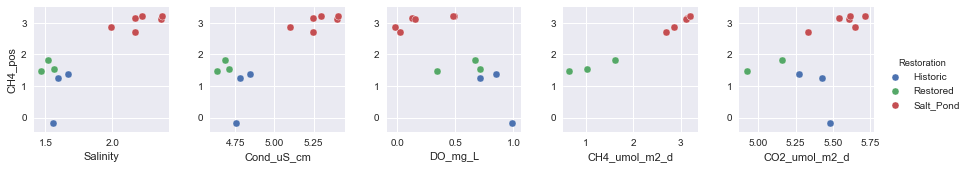

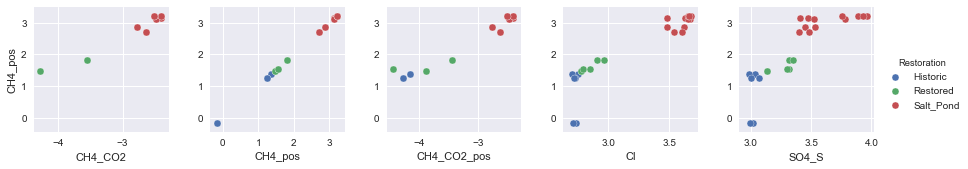

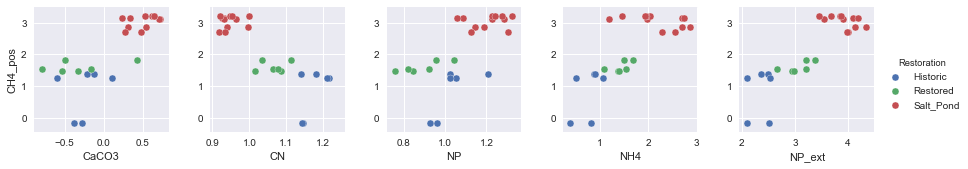

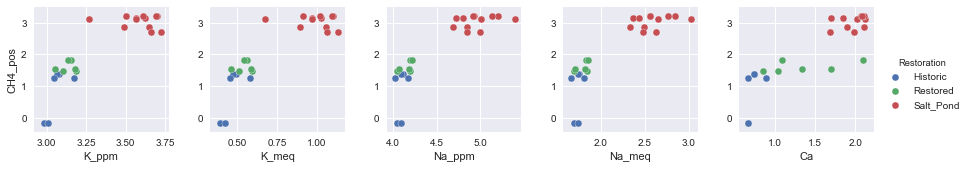

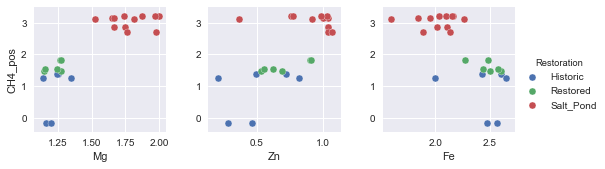

In [30]:
## log transformed
Hcor_CH4_log = np.log10(Hcor_CH4)
Hcor_CH4_metaM_log = pd.concat([Sal_metaM.iloc[:,:11],Hcor_CH4_log],1)

g1= sns.pairplot(y_vars=['CH4_pos'], x_vars = Hcor_CH4_metaM_log.columns[11:16], hue='Restoration', data=Hcor_CH4_metaM_log)
g2= sns.pairplot(y_vars=['CH4_pos'], x_vars = Hcor_CH4_metaM_log.columns[16:21], hue='Restoration', data=Hcor_CH4_metaM_log)
g3= sns.pairplot(y_vars=['CH4_pos'], x_vars = Hcor_CH4_metaM_log.columns[21:26], hue='Restoration', data=Hcor_CH4_metaM_log)
g4= sns.pairplot(y_vars=['CH4_pos'], x_vars = Hcor_CH4_metaM_log.columns[26:31], hue='Restoration', data=Hcor_CH4_metaM_log)
g5= sns.pairplot(y_vars=['CH4_pos'], x_vars = Hcor_CH4_metaM_log.columns[31:], hue='Restoration', data=Hcor_CH4_metaM_log)


In [31]:
## change CH4 <0 to 0.1 for log plot
Hcor_CH4["CH4_pl1"] = Hcor_CH4["CH4_umol_m2_d"]
Hcor_CH4.loc[Hcor_CH4["CH4_pl1"] < 0,"CH4_pl1"] = 0.1
Hcor_CH4["CN"]

0     13.956953
1     13.874564
2     15.130620
3     13.782139
4     16.433834
5     16.266288
6     10.352195
7     12.198867
8     10.789899
9     12.936325
10    11.595550
11    11.975300
12     8.700080
13     9.923873
14     8.560009
15     8.460529
16     8.268826
17     8.604831
18     9.206692
19     8.542396
20     8.346778
21     8.842089
22     9.971693
23     8.955965
Name: CN, dtype: float64

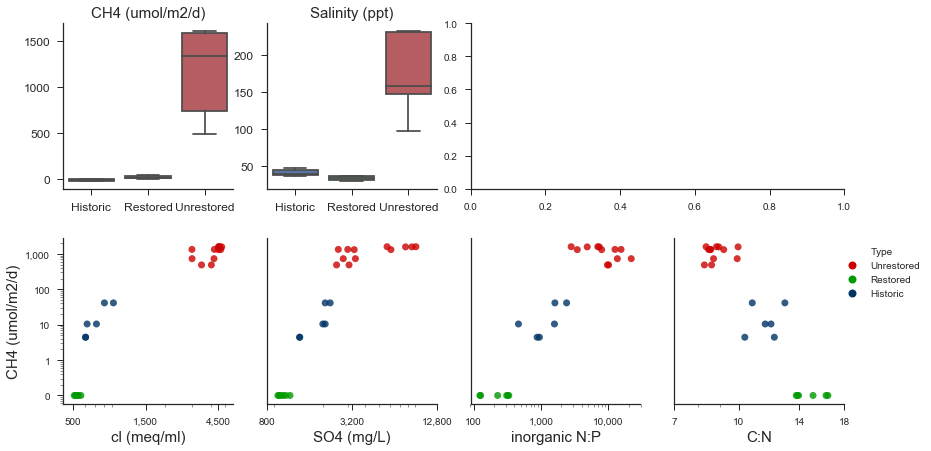

In [143]:
## color
red = ("#CC0000","#CC0000","#CC0000","#CC0000","#CC0000","#CC0000")     # R1
#orange = ('#FF6600', '#FF6600','#FF6600','#FF6600','#FF6600','#FF6600') # R2 
blue = ('#009900', '#009900','#009900','#009900','#009900','#009900')   # SF2
green = ("#003366", "#003366", "#003366", "#003366", "#003366", "#003366")    # R2A
site_colors = blue +green+  red *2

plt.figure(figsize=(14,7))

## set grid
grid = plt.GridSpec(2, 4, wspace=0.2, hspace=0.3)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[0, 2:])
ax4 = plt.subplot(grid[1, 0])
ax5 = plt.subplot(grid[1, 1])
ax6 = plt.subplot(grid[1, 2])
ax7 = plt.subplot(grid[1, 3])

## set type
sns.set_style("white")
sns.set_style("ticks")


sns.boxplot(x="Restoration", y="CH4_umol_m2_d", data=Hcor_CH4_metaM,ax=ax1)
ax1.set_title("CH4 (umol/m2/d)",fontsize=15)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(["Historic","Restored","Unrestored"])
ax1.tick_params(labelsize=12)

sns.boxplot(x="Restoration", y="Salinity", data=Hcor_CH4_metaM,ax=ax2)
ax2.set_title("Salinity (ppt)",fontsize=15)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticklabels(["Historic","Restored","Unrestored"])
ax2.tick_params(labelsize=12)

## ax4
ax4.set(xscale='log', yscale='log')
sns.regplot(y='CH4_pl1', x='Cl', fit_reg=False, marker='o', data = Hcor_CH4, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8},ax=ax4)
ax4.get_yaxis().set_major_formatter(                                      # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.yticks([100, 1000, 10000])                                            # label array
ax4.get_xaxis().set_major_formatter(                                      # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
#plt.xticks([1000, 2000])                                                  # label array
ax4.set_xticks([500,1500,4500])
ax4.set_ylabel("CH4 (umol/m2/d)", fontsize=15)
ax4.set_xlabel("cl (meq/ml)", fontsize=15)
sns.despine()


## ax5
ax5.set(xscale='log', yscale='log')
sns.regplot(y='CH4_pl1', x='SO4_S', fit_reg=False, marker='o', data = Hcor_CH4, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8},ax=ax5)
                                         # label array
ax5.get_xaxis().set_major_formatter(                                      # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
#plt.xticks([1000, 2000])                                                  # label array
ax5.set_xticks([800,3200,12800])
ax5.set_ylabel("")
ax5.get_yaxis().set_visible(False)
ax5.set_xlabel("SO4 (mg/L)", fontsize=15)

## ax6
ax6.set(xscale='log', yscale='log')

sns.regplot(y='CH4_pl1', x='NP_ext', fit_reg=False, marker='o', data = Hcor_CH4, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8},ax=ax6)  # 'facecolors':sitecolors

ax6.get_xaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
ax6.set_xticks([100,1000, 10000])  
ax6.set_xlabel("inorganic N:P", fontsize=15)

ax6.set_ylabel("")
ax6.get_yaxis().set_visible(False)

## ax7
ax7.set(xscale='log', yscale='log')
sns.regplot(y='CH4_pl1', x='CN', fit_reg=False, marker='o', data = Hcor_CH4, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8},ax=ax7)
                                         # label array
ax7.get_xaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ','))) 
ax7.set_xlim(0,18)
ax7.set_xticks([7,10,14,18]) 
ax7.set_ylabel("")
ax7.get_yaxis().set_visible(False)
ax7.set_xlabel("C:N", fontsize=15)

## Edit Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Unrestored',
                          markerfacecolor='#CC0000', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Restored',
                          markerfacecolor='#009900', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Historic',
                          markerfacecolor='#003366', markersize=8)]

ax7.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1),title="Type")

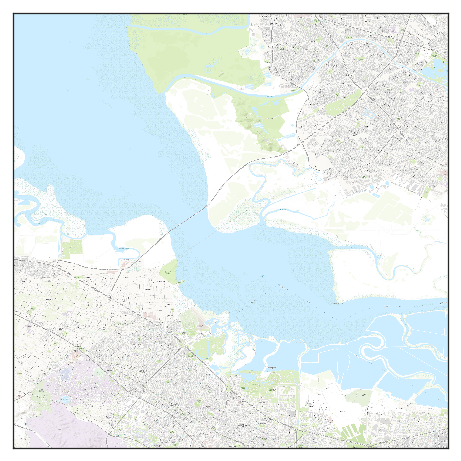

In [101]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def plot_map(service = 'World_Physical_Map', epsg = 4269, xpixels = 5000):
    # note, you need change the epsg for different region, 
    #US is 4269, and you can google the region you want
    plt.figure(figsize = (8, 8))
    m = Basemap(projection='mill',llcrnrlon=-122.2 ,llcrnrlat=37.4,
        urcrnrlon=-122 ,urcrnrlat=37.6, resolution = 'l', epsg = epsg)
    
    # llcrnrlon 左
    # urcrnrlon 右
    # llcrnrlat 下
    # urcrnrlat 上
    # xpixels controls the pixels in x direction, and if you leave ypixels
    # None, it will choose ypixels based on the aspect ratio
    m.arcgisimage(service=service, xpixels = xpixels, verbose= False)
    
    plt.show()
    
plot_map(service = 'Ocean_Basemap')

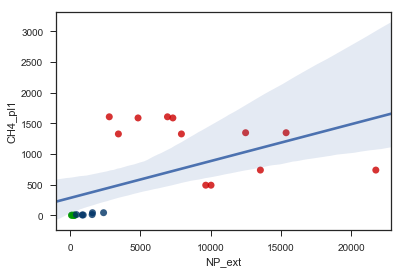

In [313]:
sns.regplot(y='CH4_pl1', x='NP_ext', fit_reg=True, marker='o', data = Hcor_CH4, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8})

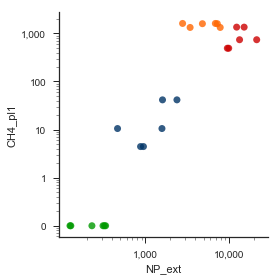

In [147]:
fig, ax = plt.subplots(figsize=(4,4))

#pp = PdfPages('SP_CH4_vs_NP_ext.pdf')     


ax.set(xscale='log', yscale='log')
sns.set_style("white")
sns.set_style("ticks")


sns.regplot(y='CH4_pl1', x='NP_ext', fit_reg=False, marker='o', data = Hcor_CH4, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8})  # 'facecolors':sitecolors

ax.get_yaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.yticks([0.1, 1, 10, 100, 1000])   

ax.get_xaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.xticks([1000, 10000])  

sns.despine()
fig.tight_layout()


## Soil Chemistry analysis

### Transform data

In [7]:
###### Make LOG 10 data sets for export
Log_Soil_chem = np.log10(Soil_chem)  # log10 SOILS data

## Add back some non-log data 
Log_Soil_chem['CH4_m2_lin'] = Soil_chem['CH4_umol_m2_d']
Log_Soil_chem['CO2_m2_lin'] = Soil_chem['CO2_umol_m2_d']
Log_Soil_chem['Salinity_lin'] = Soil_chem['Salinity']
Log_Soil_chem['pH_lin'] = Soil_chem['pH']
Log_Soil_chem['NP_ext_lin'] = Soil_chem['NP_ext']
Log_Soil_chem['NP_lin'] = Soil_chem['NP']
Log_Soil_chem['Cl_lin'] = Soil_chem['Cl']

# Replace sample info
Log_Soil_chem_info = pd.concat([Samp_info, Log_Soil_chem], axis=1)
Log_Soil_chem_info.head()

# Export
Log_Soil_chem_info.columns
Log_Soil_chem_info.to_csv('Salt_Pond_metaLOG_FIX.txt', sep='\t')
Log_Soil_chem["CH4_m2_lin"]

0      -24.30
1      -24.30
2       -1.76
3       -1.76
4       -7.10
5       -7.10
6        4.43
7        4.43
8       41.45
9       41.45
10      10.50
11      10.50
12     737.32
13     737.32
14    1347.13
15    1347.13
16     490.47
17     490.47
18    1327.18
19    1327.18
20    1607.09
21    1607.09
22    1588.57
23    1588.57
Name: CH4_m2_lin, dtype: float64

### Make heatmap--Soils

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Text yticklabel objects>)

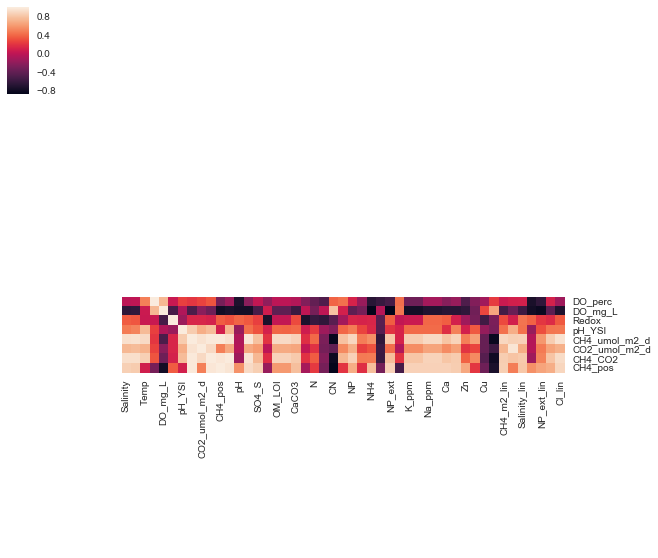

In [8]:
Soil_corr = Log_Soil_chem.corr() #correlation matrix

# Emphasize CH4 related subset
cm=sns.clustermap(Soil_corr.iloc[3:11,:], vmax=1, row_cluster=False, col_cluster=False, square=True);
# cm.cax.set_visible(False) - turns legend off, but doesn't fix whitespace
plt.sca(cm.ax_heatmap) # for tick rotation
plt.yticks(rotation=0)

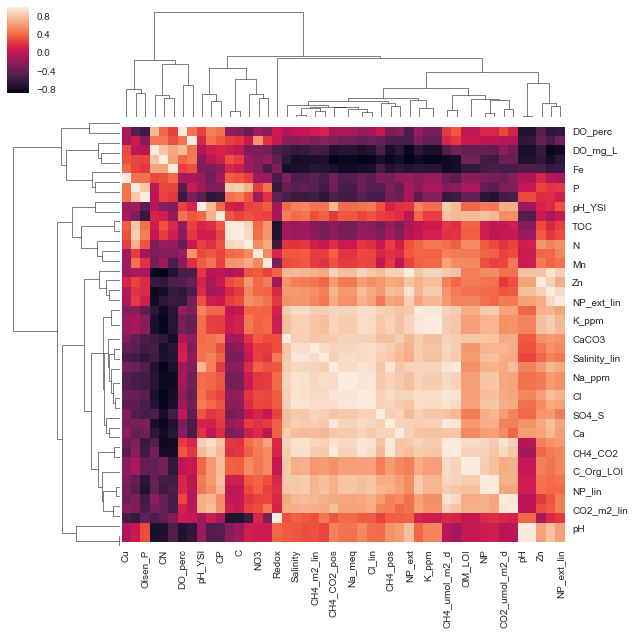

In [9]:
# Clustermap - ALL SOIL vars
cm2=sns.clustermap(Soil_corr.iloc[3:,:], vmax=1, row_cluster=True, col_cluster=True,  square=True);
plt.sca(cm2.ax_heatmap) # More on this in a minute
plt.yticks(rotation=0);


### Get best vars and scatterplot

In [10]:
## Get top correlated variables by abs
# Soil_corr = Log_Soil_chem.corr() #correlation matrix

# Get CH4 corr data and abs. values
CH4_corrs =pd.DataFrame(Soil_corr['CH4_pos'])
CH4_corrs['AbVal'] = abs(CH4_corrs)  # CH4_corrs.head(10)

# Cutoff at |r| > 0.45, sorted 
CH4_corrs_rF = CH4_corrs[CH4_corrs.AbVal > 0.7]                       # Impose cutoff,  .index gives only cols
CH4_corrs_rF = CH4_corrs_rF.sort_values(by='AbVal', ascending =0)    # make abs col
CH4_corrs_rF
CH4_corrs_rF0 = CH4_corrs_rF.iloc[3:,:]                              # drop autocorrelated, by inspection
CH4_corrs_rF10 = CH4_corrs_rF0.iloc[:,0:9]
CH4_corrs_top10 = CH4_corrs_rF10.sort_values(by='CH4_pos', ascending =0)  # sort by orig cor (not abs)  

# Get var list
CH4_top_10 = CH4_corrs_top10.iloc[:,:9].index   
CH4_top_10 
# CH4_corrs_top10 

Index(['CH4_CO2_pos', 'Cl', 'Cl_lin', 'Na_ppm', 'Na_meq', 'NP_ext', 'K_ppm',
       'K_meq', 'Ca', 'Salinity', 'CH4_m2_lin', 'SO4_S', 'Mg', 'Cond_uS_cm',
       'Salinity_lin', 'CaCO3', 'NH4', 'NP_lin', 'Fe', 'DO_mg_L', 'CN'],
      dtype='object')

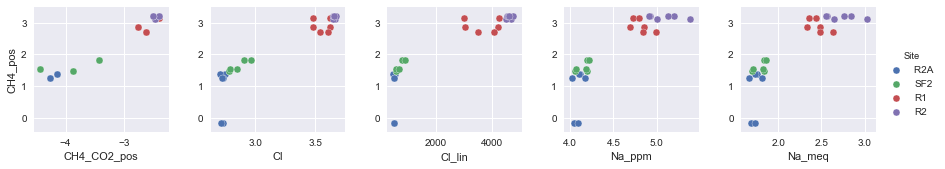

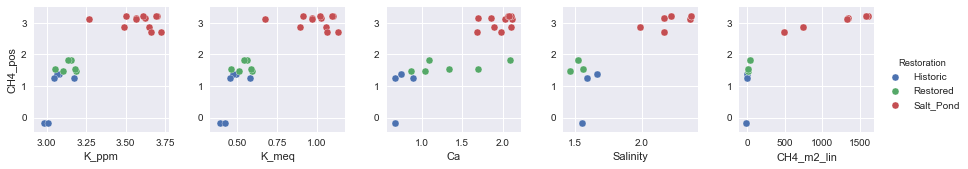

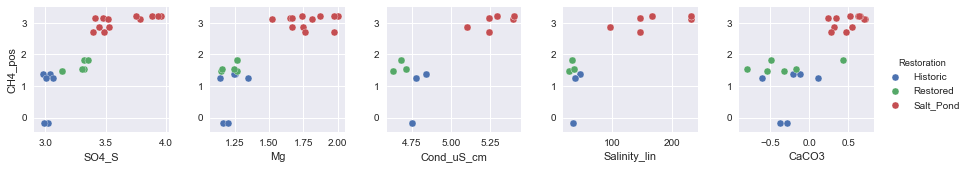

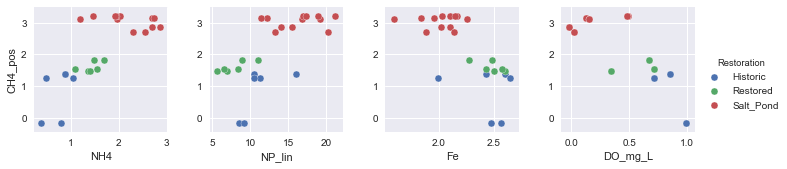

In [11]:
sns.pairplot(y_vars=['CH4_pos'], x_vars = CH4_top_10[0:5], hue='Site', data=Log_Soil_chem_info)
sns.pairplot(y_vars=['CH4_pos'], x_vars = CH4_top_10[6:11], hue='Restoration', data=Log_Soil_chem_info)
sns.pairplot(y_vars=['CH4_pos'], x_vars = CH4_top_10[11:16], hue='Restoration', data=Log_Soil_chem_info)
sns.pairplot(y_vars=['CH4_pos'], x_vars = CH4_top_10[16:20], hue='Restoration', data=Log_Soil_chem_info)


# sns.pairplot(y_vars=['CH4_ug_m2_h'], x_vars = CH4_top_10[12:14], hue='Location', hue_order=Site_or, data=Log_Soil_chem)

## Try regplot

In [12]:
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

In [13]:
# Get site colors
red = ("#CC0000","#CC0000","#CC0000","#CC0000","#CC0000","#CC0000")     # R1
orange = ('#FF6600', '#FF6600','#FF6600','#FF6600','#FF6600','#FF6600') # R2 
blue = ('#009900', '#009900','#009900','#009900','#009900','#009900')   # SF2
green = ("#003366", "#003366", "#003366", "#003366", "#003366", "#003366")    # R2A

site_colors = blue +green+  red + orange
#site_colors
Log_Soil_chem_info['CH4_m2_lin']

0      -24.30
1      -24.30
2       -1.76
3       -1.76
4       -7.10
5       -7.10
6        4.43
7        4.43
8       41.45
9       41.45
10      10.50
11      10.50
12     737.32
13     737.32
14    1347.13
15    1347.13
16     490.47
17     490.47
18    1327.18
19    1327.18
20    1607.09
21    1607.09
22    1588.57
23    1588.57
Name: CH4_m2_lin, dtype: float64

In [14]:
CH4_pl1 = pd.DataFrame(Log_Soil_chem_info['CH4_m2_lin'])
CH4_pl1[CH4_pl1 < 0] = 0.1

Log_Soil_chem_info['CH4_pl1'] = CH4_pl1
#Log_Soil_chem_info['CH4_pl1']

In [15]:
Log_Soil_chem_info.head()

,New_index,Sample_name,Sample,Site,Core,Depth,Restoration,Hydrol,Date,Lat,...,Cu,Fe,CH4_m2_lin,CO2_m2_lin,Salinity_lin,pH_lin,NP_ext_lin,NP_lin,Cl_lin,CH4_pl1
0,1,Historic_R2A_A_D1,R2A_A_D1,R2A,A,D1,Historic,Tidal marsh,7/11/14,37.496219,...,0.342423,2.471878,-24.30,300262.17,36.0,6.37,322.112865,8.484259,541,0.1
1,2,Historic_R2A_A_D2,R2A_A_D2,R2A,A,D2,Historic,Tidal marsh,7/11/14,37.496219,...,0.518514,2.565376,-24.30,300262.17,36.0,6.19,127.168786,9.174638,518,0.1
2,3,Historic_R2A_B_D1,R2A_B_D1,R2A,B,D1,Historic,Tidal marsh,7/11/14,37.496044,...,0.361728,2.430559,-1.76,187121.85,46.5,6.41,227.949095,10.548608,563,0.1
3,4,Historic_R2A_B_D2,R2A_B_D2,R2A,B,D2,Historic,Tidal marsh,7/11/14,37.496044,...,0.278754,2.604226,-1.76,187121.85,46.5,6.18,309.915042,16.091627,509,0.1
4,5,Historic_R2A_C_D1,R2A_C_D1,R2A,C,D1,Historic,Tidal marsh,7/11/14,37.496546,...,0.477121,1.997386,-7.10,266086.03,39.3,6.17,332.871712,11.275017,536,0.1


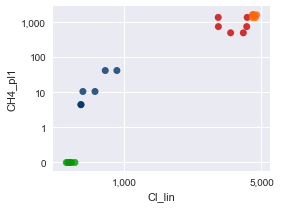

In [16]:
#plt.figure(figsize=(4,4))
fig, ax = plt.subplots(figsize=(4,3))

#pp = PdfPages('SP_CH4_vs_Cl.pdf')   

ax.set(xscale='log', yscale='log')
sns.set_style("white")
sns.set_style("ticks")



sns.regplot(y='CH4_pl1', x='Cl_lin', fit_reg=False, marker='o', data = Log_Soil_chem_info, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8})  # 'facecolors':sitecolors
#sns.regplot(y='CH4_pl1', x='NP_ext_lin', fit_reg=False, marker='o', data = Log_Soil_chem_info, 
 #           scatter_kws={'facecolors':site_colors, 'alpha':0.8})  # 'facecolors':sitecolors

ax.get_yaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.yticks([0.1, 1, 10, 100, 1000])   

ax.get_xaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.xticks([1000, 5000])  

sns.despine()
fig.tight_layout()
#pp.savefig()                             
#pp.close()   # Close the file

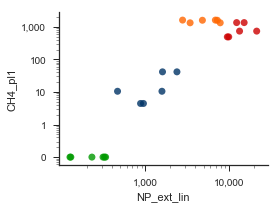

In [17]:
fig, ax = plt.subplots(figsize=(4,3))

#pp = PdfPages('SP_CH4_vs_NP_ext.pdf')     


ax.set(xscale='log', yscale='log')
sns.set_style("white")
sns.set_style("ticks")


sns.regplot(y='CH4_pl1', x='NP_ext_lin', fit_reg=False, marker='o', data = Log_Soil_chem_info, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8})  # 'facecolors':sitecolors

ax.get_yaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.yticks([0.1, 1, 10, 100, 1000])   

ax.get_xaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.xticks([1000, 10000])  

sns.despine()
fig.tight_layout()

# Save the figure PDF created at top 
#pp.savefig()                             
#pp.close()   # Close the file

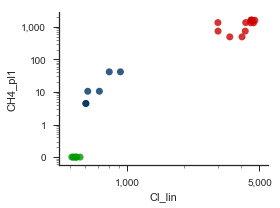

In [170]:
# N:P vs. Cl
fig, ax = plt.subplots(figsize=(4,3))

#pp = PdfPages('NP_ext_vs_Cl.pdf')   
ax.set(xscale='log', yscale='log')

sns.regplot(y='CH4_pl1', x='Cl_lin', fit_reg=False, marker='o', data = Log_Soil_chem_info, 
#sns.regplot(y='NP_ext_lin', x='Cl_lin', fit_reg=False, marker='o', data = Log_Soil_chem_info, 
           scatter_kws={'facecolors':site_colors, 'alpha':0.8})
ax.get_yaxis().set_major_formatter(                                       # not scientific label
   ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
#plt.yticks([100, 1000, 10000])                                            # label array

ax.get_xaxis().set_major_formatter(                                       # not scientific label
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))               # integer format 
plt.xticks([1000, 5000])                                            # label array

sns.despine()
fig.tight_layout()
#pp.savefig()                             
#pp.close()   # Close the file